In [39]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from cnn_finetune import make_model

from dataloader import get_flowers_dataloader, get_flowers_dataloader_with_aug
from utils import restrict_GPU_pytorch, accuracy, inverse_normalize
from train_tta_model import train_tta_model


restrict_GPU_pytorch('0')

from paths import MODEL_LOGITS_DIR
os.makedirs(MODEL_LOGITS_DIR, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using GPU:0


### Load model and dataset

In [4]:
model_name = 'resnet18'
n_classes = 102
model = make_model(
                    model_name,
                    pretrained=True,
                    num_classes=n_classes,
                    input_size=(224, 224),
                )

m_path = './saved_models/flowers102/' + model_name+ '.pth'
model.load_state_dict(torch.load(m_path))
model.eval()
model.cuda()

dataloader = get_flowers_dataloader()

### Visualize images + calculate baseline accuracy


In [5]:
n_examples = len(dataloader.dataset)
acc = 0
for data, labels in tqdm(dataloader):
    data = data.cuda()
    labels = labels.cuda()
    preds = model(data)
    batch_acc = accuracy(preds, labels)[0].item()
    acc += batch_acc * (data.shape[0]/n_examples)
    break
print("Top-1 Classification Accuracy: ", acc)

Top-1 Classification Accuracy:  0.47162140185396


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


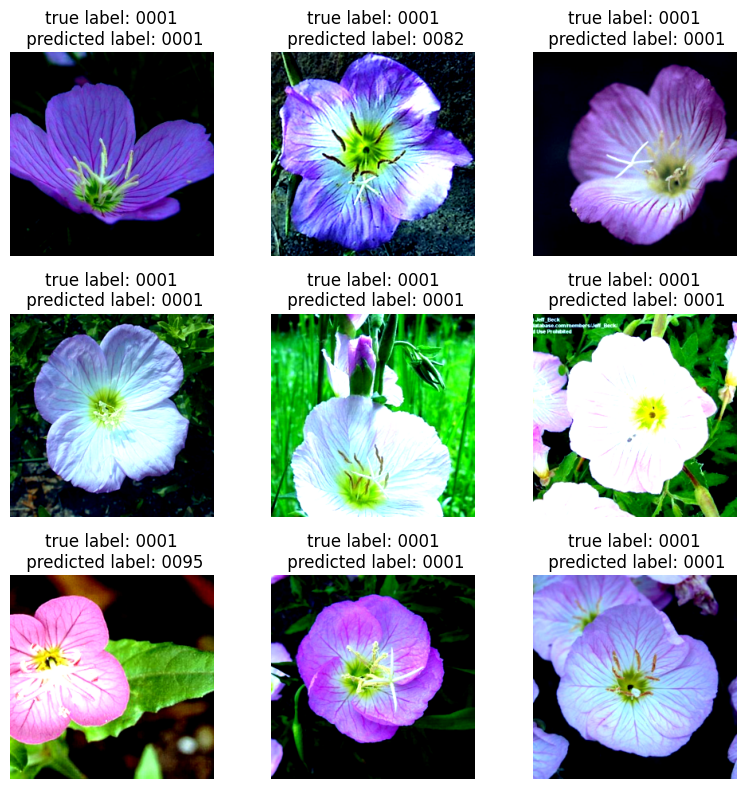

In [6]:
nc = 3
nr = 3
f, axarr = plt.subplots(nr, nc, figsize=(8, 8))

for i, ax in enumerate(axarr.ravel()):
    idx = i+9
    img = torch.clone(data[idx,:,:,:])
    img = inverse_normalize(img, torch.Tensor([.5, .5, .5]), 
                            torch.Tensor([.5, .5, .5]))
    img = img.cpu().numpy()
    img = np.moveaxis(img, 0, 2)
    true_class_name = dataloader.dataset.classes[labels[idx]]
    pred_label = np.argmax(preds.detach().cpu().numpy()[idx])
    pred_class_name = dataloader.dataset.classes[pred_label]

    ax.imshow(img)
    ax.axis('off')
    ax.set_title('true label: ' + true_class_name + '\n predicted label: ' + pred_class_name) 
plt.tight_layout()

## Implementing TTA pipeline

There are a few options for how you can implement a TTA pipeline. 

The first, and what I used in the paper, is to modify this existing library for test-time augmentations (https://github.com/qubvel/ttach). It is a little complicated and specialized to images (so I wouldn't recommend this for NLP).

The second is to define separate dataloaders for each transformation; in other words, you define dataloaders per transformation and concatenate the outputs to produce a set of transformed examples to apply the model to. 

Below is an example of the second, which I think is a bit cleaner.

In [21]:
# Create augmentation list
aug_list = ['none', 'hflip', 'cropll', 'croplr', 'cropul', 'cropur']

aug_config = {'model_name': model_name, 
              'dataset': 'Flowers102'}

def get_file_path(aug_config):
    keys = sorted(aug_config.keys())
    fpath = ''
    for key in keys:
        fpath += str(key) + ',' + str(aug_config[key]) + '_'
    return fpath[:-1]

dataloaders = [(aug_name, get_flowers_dataloader_with_aug(aug_name)) for aug_name in aug_list]
for aug_name, dataloader in dataloaders:
    aug_config['aug_name'] = aug_name
    all_preds = []
    all_labels = []
    for data, labels in tqdm(dataloader):
        data = data.cuda()
        labels = labels.cuda()
        preds = model(data)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    pred_path = MODEL_LOGITS_DIR + '/' + get_file_path(aug_config) + '_preds'
    labels_path = MODEL_LOGITS_DIR + '/' + get_file_path(aug_config) + '_labels'
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels)
    np.save(pred_path, all_preds)
    np.save(labels_path, all_labels)    

In [38]:
# Read in predicted logits for each augmentation in augmentation policy
aug_policy = ['none', 'hflip', 'cropll', 'croplr', 'cropul', 'cropur']
aug_configs = [{'model_name': model_name, 'dataset': 'Flowers102',
                'aug_name': aug_name} for aug_name in aug_policy]

all_aug_preds = []
all_aug_labels = []
for aug_config in aug_configs:
    preds_path = model_logits_dir + '/' + get_file_path(aug_config) + '_preds.npy'
    labels_path = model_logits_dir + '/' + get_file_path(aug_config) + '_labels.npy'

    all_aug_preds.append(np.load(preds_path))
    all_aug_labels.append(np.load(labels_path))

all_aug_preds = np.stack(all_aug_preds)
all_aug_preds = np.swapaxes(all_aug_preds, 0, 1)
all_aug_labels = all_aug_labels[0]

# Partition into train and test set 
all_idxs = list(range(len(all_aug_preds)))
train_idxs, test_idxs = train_test_split(all_idxs, test_size=.5)

train_aug_preds = all_aug_preds[train_idxs]
test_aug_preds = all_aug_preds[test_idxs]

train_labels = all_aug_labels[train_idxs]
test_labels = all_aug_labels[test_idxs]

print('Input shape: ', train_aug_preds.shape)
print('Target shape: ', train_labels.shape)

Input shape:  (3074, 6, 102)
Target shape:  (3074,)


In [73]:
# Evaluate different approaches to test-time augmentation
methods = ['ClassTTA', 'AugTTA', 'Mean', 'Max', 'None']
# methods = ['ClassTTA']
n_splits = 5
n_epochs = 50
results = []

expt_configs = []
for method in methods:
    expt_config = {'dataset': 'Flowers102', 'n_classes': 102, 'epochs': n_epochs, 'model_name': model_name,
                   'temp_scale': 1, 'agg_name': method, 'aug_policy':','.join(aug_policy)}
    expt_configs.append(expt_config)
    
    
for expt_config in expt_configs:
    method = expt_config['agg_name']
    
    # TODO: add in testing over multiple splits
    
    if method in ['ClassTTA', 'AugTTA']:
        model = train_tta_model(expt_config, train_aug_preds, train_labels)
        # Evaluate model on test_aug_preds, test_labels
        
        test_examples = torch.Tensor(test_aug_preds).cuda()
        preds = model(test_examples)
        preds = np.argmax(preds.detach().cpu().numpy(), axis=1)
        acc = len(np.where(preds == test_labels)[0])/len(test_labels)
        
    elif method == 'Mean':
        preds = np.argmax(np.mean(test_aug_preds, axis=1), axis=1)
        acc = len(np.where(preds == test_labels)[0])/len(test_labels)
        
    elif method == 'Max':
        preds = np.argmax(np.max(test_aug_preds, axis=1), axis=1)
        acc = len(np.where(preds == test_labels)[0])/len(test_labels)

    elif method == 'None':
        preds = np.argmax(test_aug_preds[:,0,:], axis=1)
        acc = len(np.where(preds == test_labels)[0])/len(test_labels)

    result = {'acc': acc}
    result.update(expt_config)
    results.append(result)


In [74]:
# Print table of performance
results_df = pd.DataFrame(results)
results_df 

,acc,dataset,n_classes,epochs,model_name,temp_scale,agg_name,aug_policy
0,0.905691,Flowers102,102,50,resnet18,1,ClassTTA,"none,hflip,cropll,croplr,cropul,cropur"
1,0.896911,Flowers102,102,50,resnet18,1,AugTTA,"none,hflip,cropll,croplr,cropul,cropur"
2,0.895935,Flowers102,102,50,resnet18,1,Mean,"none,hflip,cropll,croplr,cropul,cropur"
3,0.893333,Flowers102,102,50,resnet18,1,Max,"none,hflip,cropll,croplr,cropul,cropur"
4,0.894959,Flowers102,102,50,resnet18,1,None,"none,hflip,cropll,croplr,cropul,cropur"


## Experimentation tips

* Save predictions out to files: This will allow you to avoid running the model each time you need a prediction.
* Use bash scripts: These are useful for running experiments while you're away from your computer. Generally, I ssh into the servers, start a screen / tmux session, run the script.
* Identify which variables you want to log before running the experiment, and dump it all into a pandas dataframe. Write this out periodically, so you can generate results as your experiments run.

